In [67]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, mean_absolute_error
import matplotlib.pyplot as plt
from prophet import Prophet



In [68]:

df = pd.read_excel("Cleaned_Shipping_Port_Data.xlsx")


for col in ['Congestion_Date', 'Date']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')


df['TEUs_per_Ship'] = df['Cargo_Handled_Tonnes'] / df['Ships_Arrived']
df['TEUs_per_Hour'] = df['Cargo_Handled_Tonnes'] / df['Avg_Turnaround_Time_Hours']


df['Waiting_Time_hrs'] = df['Avg_Pre_Berthing_Wait_Hours']


df['Turnaround_Time_hrs'] = df['Avg_Turnaround_Time_Hours']


df['Congestion_Flag'] = (df['Weekly_Median_Congestion_Delay_Days'] > 1).astype(int)


if 'Congestion_Date' in df.columns:
    df['Weekday'] = df['Congestion_Date'].dt.day_name()
    df['Month'] = df['Congestion_Date'].dt.month
    df['Week'] = df['Congestion_Date'].dt.isocalendar().week


from sklearn.preprocessing import LabelEncoder
if 'Port_Name' in df.columns:
    df['Port_Name_Enc'] = LabelEncoder().fit_transform(df['Port_Name'])
if 'Category_of_Cargo' in df.columns:
    df['Category_of_Cargo_Enc'] = LabelEncoder().fit_transform(df['Category_of_Cargo'])
if 'Country' in df.columns:
    df['Country_Enc'] = LabelEncoder().fit_transform(df['Country'])


df.to_excel("Featured_Engineered_data.xlsx", index=False)



In [69]:

file_path = "Featured_Engineered_data.xlsx"
df = pd.read_excel(file_path)

In [ ]:
model_features = [
    "Ships_Arrived", "Ships_Departed", "Cargo_Handled_Tonnes",
    "Avg_Turnaround_Time_Hours", "TEUs_per_Ship"
]
cat_cols = []
if "Port_Name_Enc" in df.columns:
    model_features.append("Port_Name_Enc")
    cat_cols.append("Port_Name_Enc")
if "Category_of_Cargo_Enc" in df.columns:
    model_features.append("Category_of_Cargo_Enc")
    cat_cols.append("Category_of_Cargo_Enc")
if "TEUs_per_Hour" in df.columns:
    model_features.append("TEUs_per_Hour")


In [71]:
df = df.dropna(subset=model_features + ["Congestion_Flag", "Waiting_Time_hrs"])

X = df[model_features]
y_class = df["Congestion_Flag"]
y_reg = df["Waiting_Time_hrs"]



X_train, X_test, y_class_train, y_class_test, y_reg_train, y_reg_test = train_test_split(
    X, y_class, y_reg, test_size=0.2, random_state=42
)

In [72]:

# Classification
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_class_train)
# df['Predicted_Congestion_Flag'] = clf.predict(X)
# df['Congestion_Probability'] = clf.predict_proba(X)[:, 1]


RandomForestClassifier(random_state=42)

In [73]:
# Regression
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, y_reg_train)
df['Predicted_Waiting_Time_hrs'] = reg.predict(X)



In [74]:
print("Classification Accuracy:", accuracy_score(y_class_test, clf.predict(X_test)))
print("Regression MAE (hours):", mean_absolute_error(y_reg_test, reg.predict(X_test)))

Classification Accuracy: 0.75
Regression MAE (hours): 1.6692937500000016


In [75]:
#classification
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_class_train)
y_pred_logreg = logreg.predict(X_test)
print("LogReg Accuracy:", accuracy_score(y_class_test, y_pred_logreg))
df['Predicted_Congestion_Flag'] = logreg.predict(X)
df['Congestion_Probability'] = logreg.predict_proba(X)[:, 1]


LogReg Accuracy: 0.7884615384615384


In [76]:
#Regression
from xgboost import XGBRegressor
xgbr = XGBRegressor()
xgbr.fit(X_train, y_reg_train)
y_pred_xgbr = xgbr.predict(X_test)
print("XGBoost Regression MAE:", mean_absolute_error(y_reg_test, y_pred_xgbr))



XGBoost Regression MAE: 1.7861863635136528


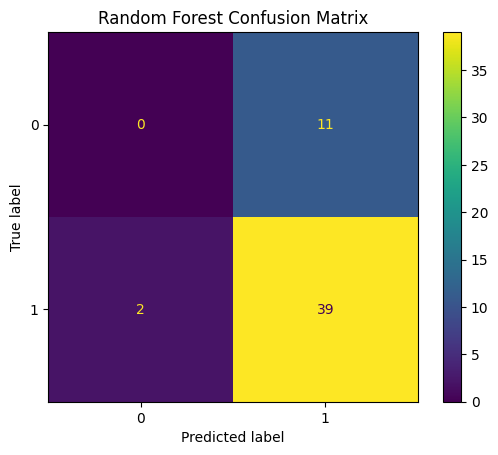

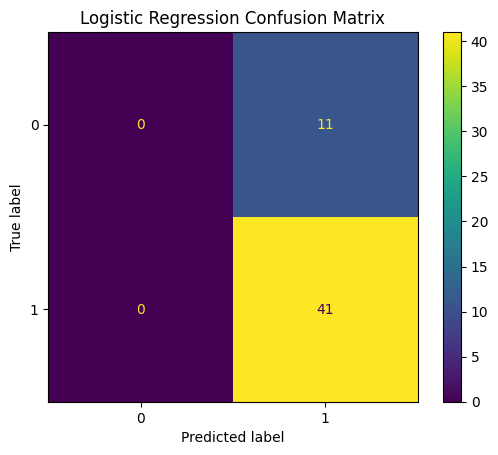

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.78      0.95      0.86        41

    accuracy                           0.75        52
   macro avg       0.39      0.48      0.43        52
weighted avg       0.61      0.75      0.68        52

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.79      1.00      0.88        41

    accuracy                           0.79        52
   macro avg       0.39      0.50      0.44        52
weighted avg       0.62      0.79      0.70        52



c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [77]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Predictions
y_pred_rf = clf.predict(X_test)
y_pred_logreg = logreg.predict(X_test)

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_class_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()
plt.title("Random Forest Confusion Matrix")
plt.show()

# Confusion Matrix for Logistic Regression
cm_logreg = confusion_matrix(y_class_test, y_pred_logreg)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg)
disp_logreg.plot()
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# Classification Report
print("Random Forest Classification Report:\n", classification_report(y_class_test, y_pred_rf))
print("Logistic Regression Classification Report:\n", classification_report(y_class_test, y_pred_logreg))


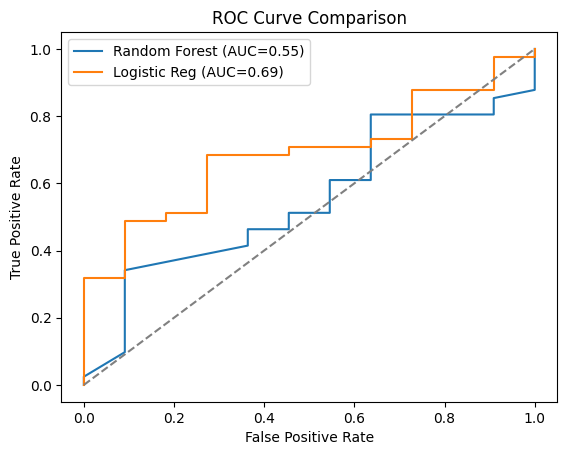

In [78]:
y_score_rf = clf.predict_proba(X_test)[:, 1]
y_score_logreg = logreg.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_class_test, y_score_rf)
fpr_logreg, tpr_logreg, _ = roc_curve(y_class_test, y_score_logreg)
auc_rf = auc(fpr_rf, tpr_rf)
auc_logreg = auc(fpr_logreg, tpr_logreg)

plt.figure()
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={auc_rf:.2f})")
plt.plot(fpr_logreg, tpr_logreg, label=f"Logistic Reg (AUC={auc_logreg:.2f})")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


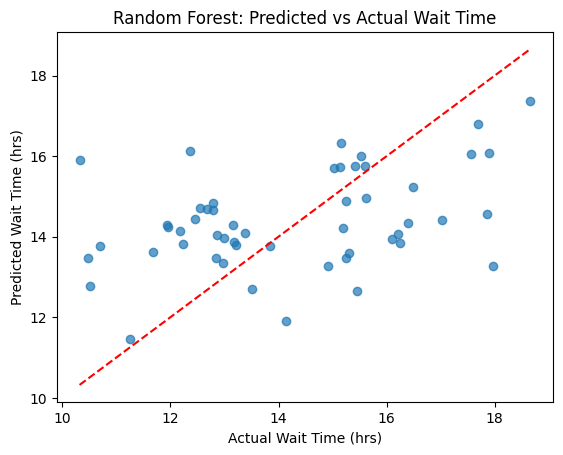

In [79]:
import matplotlib.pyplot as plt

y_pred_rf_reg = reg.predict(X_test)
plt.scatter(y_reg_test, y_pred_rf_reg, alpha=0.7)
plt.xlabel("Actual Wait Time (hrs)")
plt.ylabel("Predicted Wait Time (hrs)")
plt.title("Random Forest: Predicted vs Actual Wait Time")
plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--')  # ideal line
plt.show()


In [80]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predictions
y_pred_rf_reg = reg.predict(X_test)
y_pred_xgb_reg = xgbr.predict(X_test)

# Metrics for Random Forest
mae_rf = mean_absolute_error(y_reg_test, y_pred_rf_reg)
rmse_rf = mean_squared_error(y_reg_test, y_pred_rf_reg, squared=False)
r2_rf = r2_score(y_reg_test, y_pred_rf_reg)

# Metrics for XGBoost
mae_xgb = mean_absolute_error(y_reg_test, y_pred_xgb_reg)
rmse_xgb = mean_squared_error(y_reg_test, y_pred_xgb_reg, squared=False)
r2_xgb = r2_score(y_reg_test, y_pred_xgb_reg)

# Print table
print(f"{'Model':<20} {'MAE':<10} {'RMSE':<10} {'R2 Score'}")
print(f"{'Random Forest':<20} {mae_rf:<10.2f} {rmse_rf:<10.2f} {r2_rf:.2f}")
print(f"{'XGBoost':<20} {mae_xgb:<10.2f} {rmse_xgb:<10.2f} {r2_xgb:.2f}")



Model                MAE        RMSE       R2 Score
Random Forest        1.67       2.01       0.14
XGBoost              1.79       2.18       -0.01


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


09:57:31 - cmdstanpy - INFO - Chain [1] start processing
09:57:31 - cmdstanpy - INFO - Chain [1] done processing


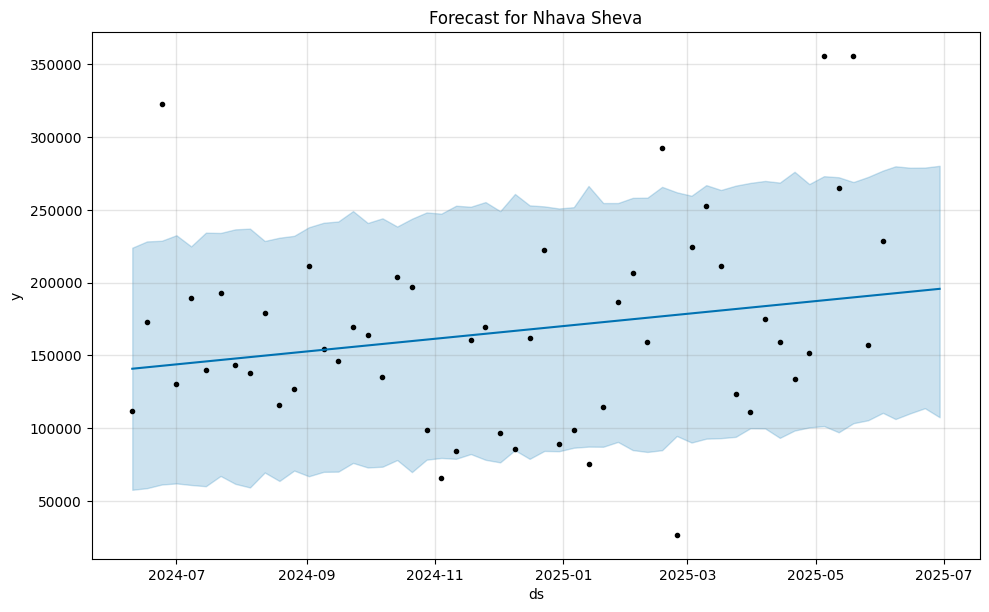

09:57:31 - cmdstanpy - INFO - Chain [1] start processing
09:57:32 - cmdstanpy - INFO - Chain [1] done processing


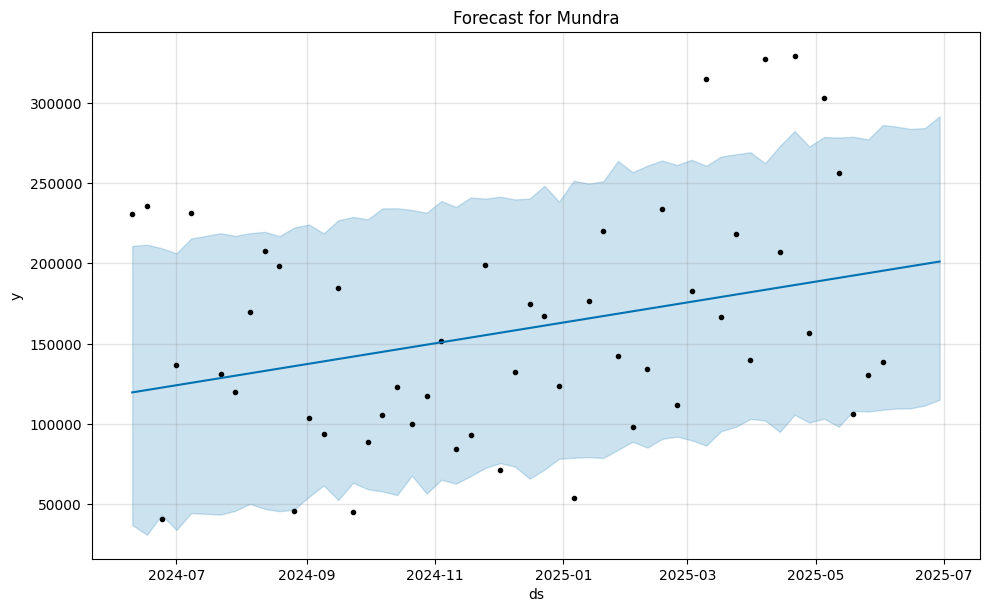

09:57:32 - cmdstanpy - INFO - Chain [1] start processing
09:57:32 - cmdstanpy - INFO - Chain [1] done processing


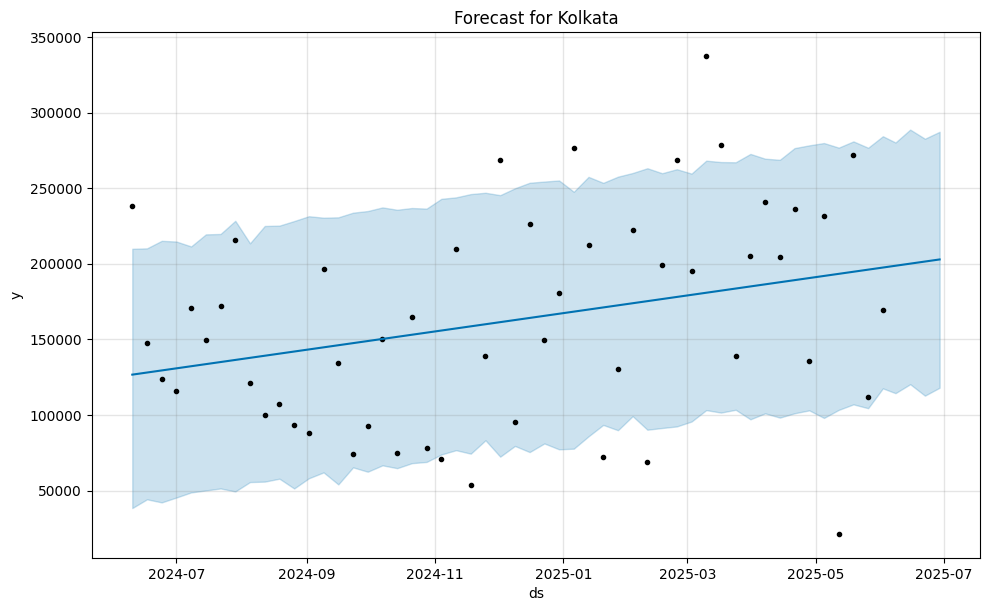

09:57:32 - cmdstanpy - INFO - Chain [1] start processing
09:57:32 - cmdstanpy - INFO - Chain [1] done processing


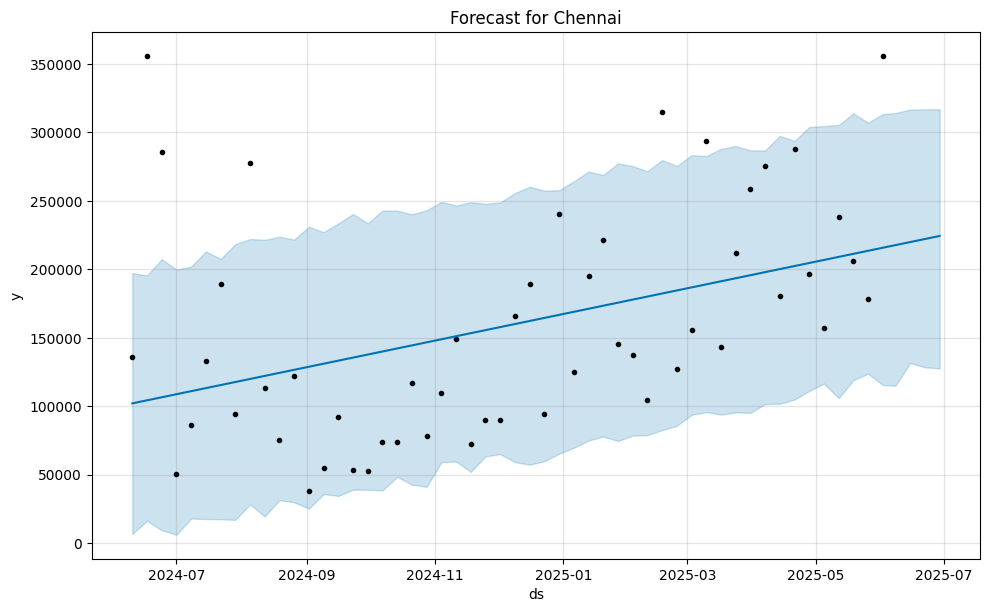

09:57:33 - cmdstanpy - INFO - Chain [1] start processing
09:57:33 - cmdstanpy - INFO - Chain [1] done processing


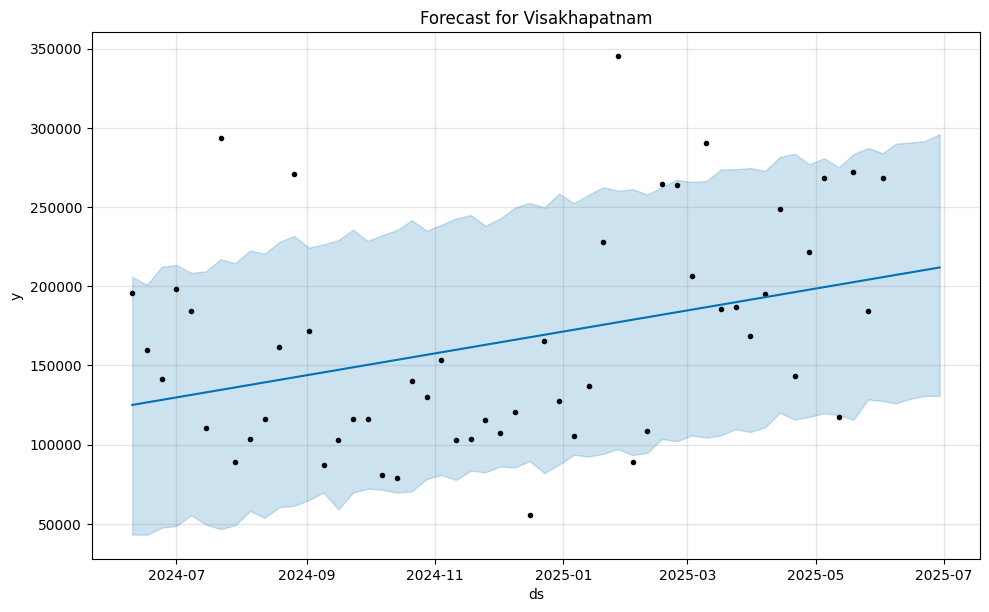

In [81]:
#time series forecasting

forecast_results = []
for port in df['Port_Name'].unique():
    dfx = df[df['Port_Name'] == port].sort_values('Congestion_Date')
    if dfx.shape[0] < 10:
        continue
    ts_df = dfx[['Congestion_Date', 'Cargo_Handled_Tonnes']].rename(
        columns={'Congestion_Date': 'ds', 'Cargo_Handled_Tonnes': 'y'}
    )
    ts_df = ts_df.dropna()
    model = Prophet()
    model.fit(ts_df)
    future = model.make_future_dataframe(periods=4, freq='W')
    forecast = model.predict(future)
    forecast = forecast[['ds', 'yhat']].tail(4).copy()
    forecast['Port_Name'] = port
    forecast = forecast.rename(columns={'ds':'Forecast_Week', 'yhat':'Forecast_Cargo_Handled_Tonnes'})
    forecast_results.append(forecast)
   
    model.plot(model.predict(future))
    plt.title(f"Forecast for {port}")
    plt.show()


if forecast_results:
    ts_forecast_df = pd.concat(forecast_results, ignore_index=True)
    ts_forecast_df.to_excel("Port_Cargo_Forcast.xlsx", index=False)
    


In [82]:
if forecast_results:
    ts_forecast_df = pd.concat(forecast_results, ignore_index=True)
  
    ts_forecast_df.to_excel("Port_Cargo_Forcast.xlsx", index=False)

In [83]:

df.to_excel(r"C:\Users\HP\Desktop\6611\Predicted_Port_Congestion_6611.xlsx", index=False)